In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,AvgPool2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.listdir('/content/drive/MyDrive/Train')

['Reversed', 'Normal', 'Corrected']

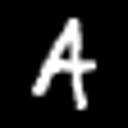

In [4]:
im =Image.open('/content/drive/MyDrive/Train/Normal/A-0.png').resize((128,128))
im

In [5]:
Corrected = os.listdir('/content/drive/MyDrive/Train/Corrected')
Normal = os.listdir('/content/drive/MyDrive/Train/Normal')
Reversal = os.listdir('/content/drive/MyDrive/Train/Reversed')
data=np.concatenate([Corrected,Normal,Reversal])
len(data)==len(Corrected)+len(Normal)+len(Reversal)

True

In [6]:
target_x=np.full(len(Normal),1)
target_y=np.full(len(Reversal),0)
target_z=np.full(len(Corrected),0)
data_target=np.concatenate([target_x,target_y,target_z])
len(data_target)==len(target_x)+len(target_y)+len(target_z)

True

In [7]:
data_target

array([1, 1, 1, ..., 0, 0, 0])

In [8]:
Corrected_values=os.listdir('/content/drive/MyDrive/Train/Corrected')
Normal_values=os.listdir('/content/drive/MyDrive/Train/Normal')
Reversal_values=os.listdir('/content/drive/MyDrive/Train/Reversed')
X_data =[]
for file in Corrected_values:
    img = cv2.imread('/content/drive/MyDrive/Train/Corrected/'+file)
    face = cv2.resize(img, (28, 28))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)
for file in Normal_values:
    img = cv2.imread('/content/drive/MyDrive/Train/Normal/'+file)
    face = cv2.resize(img, (28, 28))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)
for file in Reversal_values:
    img = cv2.imread('/content/drive/MyDrive/Train/Reversed/'+file)
    face = cv2.resize(img, (28, 28))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)

len(X_data)==len(data)==len(data_target)

True

In [9]:
X = np.squeeze(X_data)
X.shape
# normalize data
X = X.astype('float32')
X /= 255

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, data_target, test_size = 0.2, random_state = 0, stratify = data_target)

In [34]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28, 3)))
model.add(MaxPooling2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPooling2D(strides=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1200)              0         
                                                                 
 dense_3 (Dense)             (None, 256)              

In [35]:
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=5e-4)
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
# Set a learning rate annealer
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [37]:
# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            zoom_range=0.1)
datagen.fit(x_train)

In [38]:
history=model.fit(x_train, y_train, batch_size=10, steps_per_epoch=len(x_train)/100, epochs=30, validation_data=(x_test, y_test), callbacks=[reduce_lr])

Epoch 1/30
24/24 [==============================] - 2s 52ms/step - loss: 0.6993 - accuracy: 0.6400 - val_loss: 0.6016 - val_accuracy: 0.6537 - lr: 5.0000e-04
Epoch 2/30
24/24 [==============================] - 1s 46ms/step - loss: 0.6288 - accuracy: 0.6400 - val_loss: 0.5937 - val_accuracy: 0.6894 - lr: 5.0000e-04
Epoch 3/30
24/24 [==============================] - 1s 46ms/step - loss: 0.6145 - accuracy: 0.7200 - val_loss: 0.6463 - val_accuracy: 0.6569 - lr: 5.0000e-04
Epoch 4/30
24/24 [==============================] - 1s 46ms/step - loss: 0.6108 - accuracy: 0.6840 - val_loss: 0.5550 - val_accuracy: 0.6976 - lr: 5.0000e-04
Epoch 5/30
24/24 [==============================] - 1s 45ms/step - loss: 0.5787 - accuracy: 0.6680 - val_loss: 0.5910 - val_accuracy: 0.6862 - lr: 5.0000e-04
Epoch 6/30
24/24 [==============================] - 1s 44ms/step - loss: 0.5906 - accuracy: 0.6920 - val_loss: 0.5983 - val_accuracy: 0.6959 - lr: 5.0000e-04
Epoch 7/30
24/24 [==============================] - 

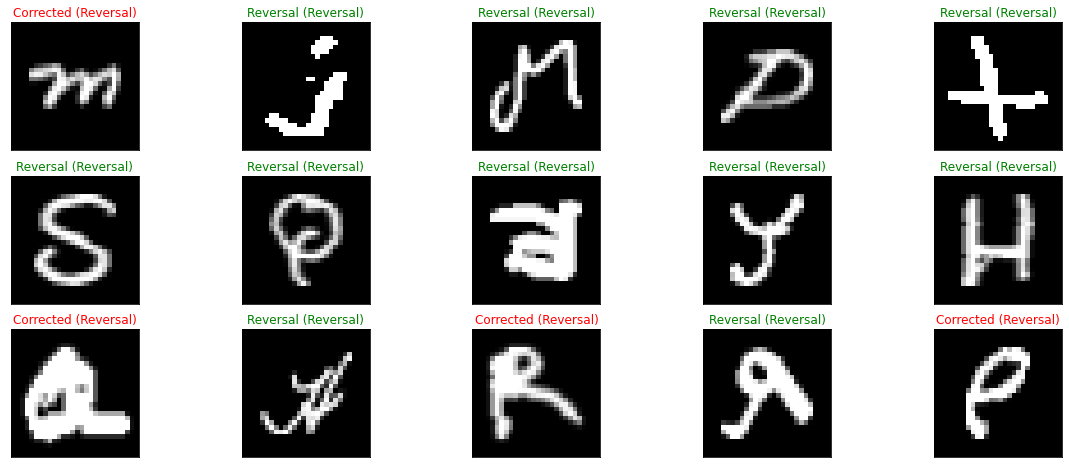

In [39]:
labels =["Reversal", "Corrected",
        "Normal",      # index 1
        ]
y_hat = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()

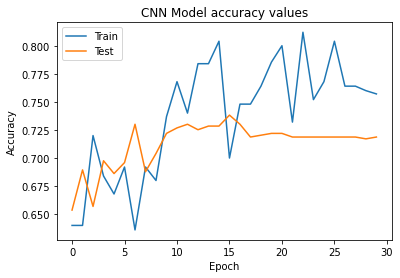

In [40]:
_# Plot training & validation loss values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#model = ...  # Get model (Sequential, Functional Model, or Model subclass)
model.save('LeNet5.h5')

In [41]:
y_test_arg=np.argmax(y_test,axis=0)
#Y_pred = np.argmax(model.predict(x_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_hat))

Confusion Matrix


TypeError: ignored

In [21]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_hat, labels=np.unique(y_hat)))

ValueError: ignored

In [22]:
print(f"Accuracy Score: %{metrics.accuracy_score(y_test, y_hat,normalize=False)}")

ValueError: ignored

In [23]:
predictions = model.predict(x_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

ValueError: ignored

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

ValueError: ignored

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
tf.random.set_seed(0)

# generate the data
X, y = make_classification(n_classes=2, n_features=4, n_informative=4, n_redundant=0, random_state=42)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# build the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(4,)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, input_dim=1, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# fit the model
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy', 'AUC'])
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), validation_batch_size=64, verbose=0)

# extract the predicted probabilities
p_pred = model.predict(X_test)
p_pred = p_pred.flatten()
print(p_pred.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)
# [1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 ...

print(confusion_matrix(y_test, y_pred))
# [[13  1]
#  [ 2  9]]

print(classification_report(y_test, y_pred))
#               precision    recall  f1-score   support
#            0       0.87      0.93      0.90        14
#            1       0.90      0.82      0.86        11
#     accuracy                           0.88        25
#    macro avg       0.88      0.87      0.88        25
# weighted avg       0.88      0.88      0.88        25